<a href="https://colab.research.google.com/github/seonghunlee94/AI_study/blob/master/1%EC%A3%BC%EC%B0%A8_%EC%8B%AC%ED%99%94%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [심화과제] MNIST 예측 모델에 deep learning techniques 적용하기


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

### 1. Dataset 및 activation 함수 변경


### 1-1 Dataset을 MNIST에서 CIFAR10으로 변경해줍니다.


In [3]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.CIFAR10( ## [MYCODE] CIFAR10
    root='./data',
    train=True,
    download=True,
    transform=transform
)

## [MYCODE] testset
testset = torchvision.datasets.CIFAR10( ## [MYCODE] CIFAR10
    root='./data',
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 170M/170M [00:03<00:00, 48.3MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


50000
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
torch.Size([3, 32, 32]) 6


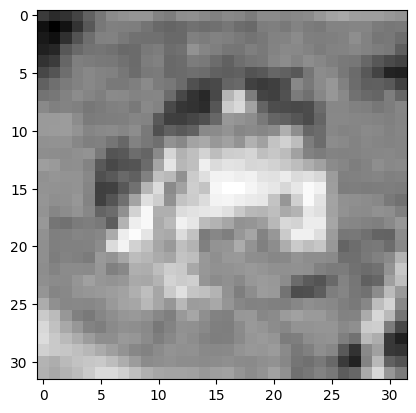

In [4]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset.classes)
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

### 1-3 학습 인자는 n_epochs = 50, batch_size = 256로 설정합니다.

In [5]:
batch_size = 256 ## [MYCODE] batch_size = 256

trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True
)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False
)


### 2. CIFAR10의 입력 shape 확인

In [6]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


### 1-2 Activation 함수를 nn.ReLU에서 nn.LeakyReLU로 변경해줍니다.

In [7]:
from torch import nn


class Model(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU() ## [MYCODE] LeakyReLU

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


model = Model(32 * 32 * 3, 1024) ## [MYCODE] 입력 차원 - Shape랑 맞쳐주기.

In [8]:
model.parameters()

<generator object Module.parameters at 0x7aba33e7fa70>

In [9]:
for param in model.parameters():
  print(param.shape)

torch.Size([1024, 3072])
torch.Size([1024])
torch.Size([1024, 1024])
torch.Size([1024])
torch.Size([10, 1024])
torch.Size([10])


### 3. SGD와 Adam 성능 비교


### 3-1 Adam optimizer을 사용하여 학습하는 코드를 구현합니다.

In [10]:
from torch.optim import SGD, Adam

lr = 0.001
model = model.to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer_sgd = SGD(model.parameters(), lr=lr, momentum=0.9)

optimizer_adam = Adam(model.parameters(), lr=lr) ## [MYCODE] Adam

In [11]:
train_sgd_accs = []
test_sgd_accs = []

train_adam_accs = []
test_adam_accs = []

In [12]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [13]:
import numpy as np

def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

### 1-3 학습 인자는 n_epochs = 50, batch_size = 256로 설정합니다.

In [14]:
n_epochs = 50 ## [MYCODE] n_epochs = 50

for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    #print(preds.shape, labels.shape)
    #break
    loss = criterion(preds, labels)
    loss.backward()
    optimizer_sgd.step()

    total_loss += loss.item()

  # 직접 작성
  train_acc = accuracy(model, trainloader)
  test_acc = accuracy(model, testloader)
  train_sgd_accs.append(train_acc)
  test_sgd_accs.append(test_acc)

  print(f"Epoch {epoch:3d} | Loss: {total_loss} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

Epoch   0 | Loss: 445.0347521305084 | Train Acc: 0.2246 | Test Acc: 0.2240
Epoch   1 | Loss: 428.29803824424744 | Train Acc: 0.2563 | Test Acc: 0.2562
Epoch   2 | Loss: 410.9425325393677 | Train Acc: 0.2780 | Test Acc: 0.2744
Epoch   3 | Loss: 396.4647316932678 | Train Acc: 0.3097 | Test Acc: 0.3027
Epoch   4 | Loss: 379.97491705417633 | Train Acc: 0.3245 | Test Acc: 0.3191
Epoch   5 | Loss: 371.9984200000763 | Train Acc: 0.3369 | Test Acc: 0.3333
Epoch   6 | Loss: 366.5014455318451 | Train Acc: 0.3455 | Test Acc: 0.3400
Epoch   7 | Loss: 361.8308011293411 | Train Acc: 0.3568 | Test Acc: 0.3521
Epoch   8 | Loss: 357.3060734272003 | Train Acc: 0.3660 | Test Acc: 0.3620
Epoch   9 | Loss: 353.1909364461899 | Train Acc: 0.3738 | Test Acc: 0.3729
Epoch  10 | Loss: 349.25117123126984 | Train Acc: 0.3730 | Test Acc: 0.3738
Epoch  11 | Loss: 345.6527991294861 | Train Acc: 0.3830 | Test Acc: 0.3855
Epoch  12 | Loss: 342.3711504936218 | Train Acc: 0.3892 | Test Acc: 0.3919
Epoch  13 | Loss: 339.

### 3-1 Adam optimizer을 사용하여 학습하는 코드를 구현합니다.

In [15]:
for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer_adam.step()

    total_loss += loss.item()

  train_acc = accuracy(model, trainloader)
  test_acc = accuracy(model, testloader)
  train_adam_accs.append(train_acc)
  test_adam_accs.append(test_acc)

  print(f"Epoch {epoch:3d} | Loss: {total_loss} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

Epoch   0 | Loss: 434.88820815086365 | Train Acc: 0.4008 | Test Acc: 0.3983
Epoch   1 | Loss: 325.61639285087585 | Train Acc: 0.4177 | Test Acc: 0.4124
Epoch   2 | Loss: 307.53505432605743 | Train Acc: 0.4481 | Test Acc: 0.4438
Epoch   3 | Loss: 295.9785507917404 | Train Acc: 0.4621 | Test Acc: 0.4498
Epoch   4 | Loss: 288.594321846962 | Train Acc: 0.4820 | Test Acc: 0.4646
Epoch   5 | Loss: 281.18153500556946 | Train Acc: 0.4993 | Test Acc: 0.4791
Epoch   6 | Loss: 275.68824315071106 | Train Acc: 0.5118 | Test Acc: 0.4903
Epoch   7 | Loss: 268.45937144756317 | Train Acc: 0.5108 | Test Acc: 0.4818
Epoch   8 | Loss: 264.5369086265564 | Train Acc: 0.5261 | Test Acc: 0.4930
Epoch   9 | Loss: 260.6629910469055 | Train Acc: 0.5472 | Test Acc: 0.5069
Epoch  10 | Loss: 254.47015845775604 | Train Acc: 0.5559 | Test Acc: 0.5120
Epoch  11 | Loss: 249.79278218746185 | Train Acc: 0.5589 | Test Acc: 0.5020
Epoch  12 | Loss: 244.16228830814362 | Train Acc: 0.5756 | Test Acc: 0.5204
Epoch  13 | Loss:

In [16]:
idx = 0

x = trainset[idx][0][None]
x = x.to('cuda')

print(model(x))
print(trainset[idx][1])

tensor([[ 2.5553, -0.0740,  4.0428,  6.5339,  4.8128,  5.9219,  9.6351,  3.7558,
         -0.0486, -0.0659]], device='cuda:0', grad_fn=<LeakyReluBackward0>)
6


### 3-2 정확도 plot

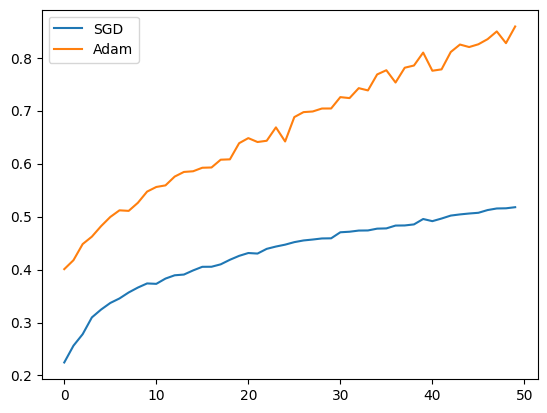

In [17]:
plot_acc(train_sgd_accs, train_adam_accs, 'SGD', 'Adam'); ## [MYCODE] plot1

## 4. Leaky ReLU와 Sigmoid 성능 비교

### 4-1 Activation 함수가 nn.Sigmoid인 class를 새로 정의합니다.

In [18]:
from torch import nn


class Model_sigmoid(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.Sigmoid() ## [MYCODE] Sigmoid

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x


model_sigmoid = Model_sigmoid(32 * 32 * 3, 1024) ## [MYCODE] 입력 차원 - Shape랑 맞쳐주기.
model_sigmoid = model_sigmoid.to('cuda')

In [19]:
model_sigmoid.parameters()

<generator object Module.parameters at 0x7aba0dda26c0>

In [20]:
train_sigmoid_accs = []
test_sigmoid_accs = []

In [21]:
optimizer_adam_sigmoid = Adam(model_sigmoid.parameters(), lr=lr) ## [MYCODE] Adam sigmoid optimaizer

In [22]:
for epoch in range(n_epochs):
  total_loss = 0.
  for data in trainloader:
    optimizer_adam_sigmoid.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model_sigmoid(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer_adam_sigmoid.step()

    total_loss += loss.item()

  train_acc = accuracy(model_sigmoid, trainloader)
  test_acc = accuracy(model_sigmoid, testloader)
  train_sigmoid_accs.append(train_acc)
  test_sigmoid_accs.append(test_acc)

  print(f"Epoch {epoch:3d} | Loss: {total_loss} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

Epoch   0 | Loss: 411.9720619916916 | Train Acc: 0.3003 | Test Acc: 0.3000
Epoch   1 | Loss: 394.9290255308151 | Train Acc: 0.3659 | Test Acc: 0.3598
Epoch   2 | Loss: 388.3141143321991 | Train Acc: 0.3670 | Test Acc: 0.3673
Epoch   3 | Loss: 383.80438256263733 | Train Acc: 0.3865 | Test Acc: 0.3840
Epoch   4 | Loss: 381.6131761074066 | Train Acc: 0.3567 | Test Acc: 0.3547
Epoch   5 | Loss: 380.3869421482086 | Train Acc: 0.3835 | Test Acc: 0.3855
Epoch   6 | Loss: 378.9313757419586 | Train Acc: 0.3914 | Test Acc: 0.3855
Epoch   7 | Loss: 376.1131510734558 | Train Acc: 0.4227 | Test Acc: 0.4161
Epoch   8 | Loss: 375.5036815404892 | Train Acc: 0.4211 | Test Acc: 0.4118
Epoch   9 | Loss: 374.2102988958359 | Train Acc: 0.4371 | Test Acc: 0.4336
Epoch  10 | Loss: 372.20754134655 | Train Acc: 0.4460 | Test Acc: 0.4369
Epoch  11 | Loss: 371.2399423122406 | Train Acc: 0.4315 | Test Acc: 0.4233
Epoch  12 | Loss: 371.6247615814209 | Train Acc: 0.4604 | Test Acc: 0.4474
Epoch  13 | Loss: 368.5618

### 4-2 (Plot 2) Adam optimizer를 가지고 sigmoid와 leaky ReLU 모델들을 학습한 후, epoch에 따른 train 정확도를 비교합니다.

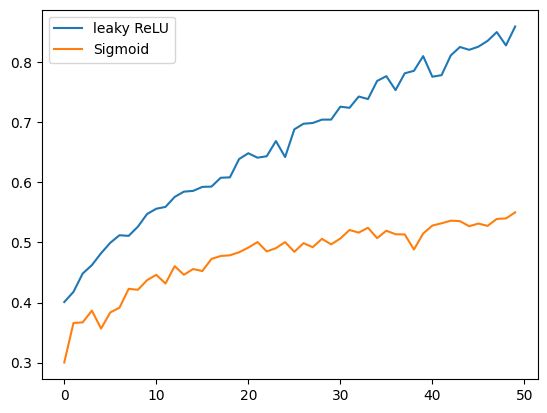

In [23]:
plot_acc(train_adam_accs, train_sigmoid_accs, 'leaky ReLU', 'Sigmoid'); ## [MYCODE] plot2

## 5. Dropout을 적용한 이후의 generalization error 확인

### 5-1 PyTorch dropout을 leaky ReLU를 사용하는 MLP의 모든 layer에 적용한 class를 새로 정의합니다. Dropout 확률은 0.1로 설정합니다.

In [24]:
from torch import nn


class Model_drop(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.drop_out = nn.Dropout(0.1) ## [MYCODE] dropout
    self.layer3 = nn.Linear(n_dim, 10)

    self.act = nn.LeakyReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.drop_out(x) ## [MYCODE] dropout
    x = self.act(self.layer2(x))
    x = self.drop_out(x) ## [MYCODE] dropout
    x = self.act(self.layer3(x))

    return x


model_drop = Model_drop(32 * 32 * 3, 1024)
model_drop = model_drop.to('cuda')

In [25]:
train_drop_accs = []
test_drop_accs = []

In [26]:
optimizer_adam_drop = Adam(model_drop.parameters(), lr=lr)

### 5-2 학습 코드에서 다음 부분들을 추가해줍니다:
### model.train()을 for data in trainloader: 이전 줄에 둡니다.
### trainloader와 testloader에 대한 정확도를 계산하는 코드를 다음과 같이 변경합니다

In [27]:
for epoch in range(n_epochs):
  total_loss = 0.
  model_drop.train() ## [MYCODE] model_drop.train()
  for data in trainloader:
    optimizer_adam_drop.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model_drop(inputs)
    loss = criterion(preds, labels)
    loss.backward()
    optimizer_adam_drop.step()

    total_loss += loss.item()

  ## [MYCODE] model_drop.eval()
  with torch.no_grad():
    model_drop.eval()
    train_acc = accuracy(model_drop, trainloader)
    test_acc = accuracy(model_drop, testloader)
  train_drop_accs.append(train_acc)
  test_drop_accs.append(test_acc)

  print(f"Epoch {epoch:3d} | Loss: {total_loss} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

Epoch   0 | Loss: 426.5816578865051 | Train Acc: 0.2314 | Test Acc: 0.2321
Epoch   1 | Loss: 387.34734559059143 | Train Acc: 0.3092 | Test Acc: 0.3069
Epoch   2 | Loss: 364.2114324569702 | Train Acc: 0.3608 | Test Acc: 0.3603
Epoch   3 | Loss: 344.91727590560913 | Train Acc: 0.3785 | Test Acc: 0.3845
Epoch   4 | Loss: 335.50337386131287 | Train Acc: 0.4018 | Test Acc: 0.4014
Epoch   5 | Loss: 326.5970890522003 | Train Acc: 0.4139 | Test Acc: 0.4115
Epoch   6 | Loss: 318.79335737228394 | Train Acc: 0.4326 | Test Acc: 0.4320
Epoch   7 | Loss: 312.16557919979095 | Train Acc: 0.4519 | Test Acc: 0.4462
Epoch   8 | Loss: 305.4963618516922 | Train Acc: 0.4504 | Test Acc: 0.4432
Epoch   9 | Loss: 299.99596536159515 | Train Acc: 0.4662 | Test Acc: 0.4499
Epoch  10 | Loss: 294.9535388946533 | Train Acc: 0.4830 | Test Acc: 0.4698
Epoch  11 | Loss: 289.76184380054474 | Train Acc: 0.4962 | Test Acc: 0.4812
Epoch  12 | Loss: 285.8641308546066 | Train Acc: 0.4944 | Test Acc: 0.4814
Epoch  13 | Loss: 

### 5-3 (Plot 3) Adam optimizer를 가지고 dropout을 적용한 모델을 학습한 후, epoch에 따른 train과 test 정확도를 비교합니다.

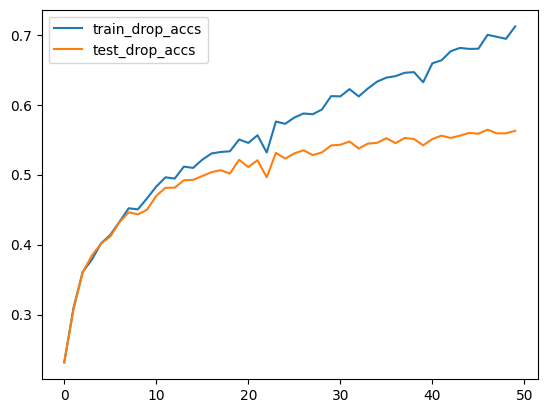

In [28]:
plot_acc(train_drop_accs, test_drop_accs, 'train_drop_accs', 'test_drop_accs'); ## [MYCODE] plot3